# **Enhancing Object Detection in YOLOS-Small through Advanced LoRA Methods**


# NOTE: This file is intended for DISPLAY PURPOSES ONLY and will NOT run independently.  
For full execution, please refer to the complete script:  


```
Enhancing_YOLOS_S_through_Advanced_LoRA_Methods.py
```


This file contains extracted sections to showcase outputs in GitHub.


## **5. mAP Evaluation**

### Visualization Function

In [ ]:
def visualize_bounding_boxes(image, results, id2label, title):
    draw = ImageDraw.Draw(image)
    for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
        box = [round(i, 2) for i in box.tolist()]
        x, y, x2, y2 = tuple(box)
        draw.rectangle((x, y, x2, y2), outline="red", width=2)
        draw.text((x, y), id2label[label.item()], fill="white")
    plt.figure(figsize=(12, 8))
    plt.title(title)
    plt.imshow(image)
    plt.axis("off")
    plt.show()


### Evaluate Model using mAP Function

In [ ]:
def evaluate_model(model, processor, data, id2label, confidence_threshold=0.5, iou_threshold=0.5, add_class_metrices=False):
    model.eval()

    # mAP for COCO benchmarks - define IoU thresholds ranging from 0.5 to 0.95
    iou_thresholds_for_mAP = torch.arange(0.5, 1.0, 0.05).tolist()

    if add_class_metrices:
        metric = MeanAveragePrecision(iou_thresholds=iou_thresholds_for_mAP, class_metrics=True)
    else:
        metric = MeanAveragePrecision(iou_thresholds=iou_thresholds_for_mAP)

    results = []
    references = []
    first_image_flag = True

    for sample in tqdm(data):
        idx = sample["image_id"]
        image = sample["image"]
        if image.mode != "RGB": # Convert to RGB (3 channels)
            image = image.convert("RGB")

        inputs = processor(images=image, return_tensors="pt").to(device)

        outputs = model(**inputs) # bboxes and logits
        target_sizes = torch.tensor([image.size[::-1]], device=device)
        processed_outputs = processor.post_process_object_detection(outputs=outputs, target_sizes=target_sizes, threshold=confidence_threshold)[0]

        if first_image_flag:
            for score, label, box in zip(processed_outputs["scores"], processed_outputs["labels"], processed_outputs["boxes"]):
                box = [round(i, 2) for i in box.tolist()]
                print(
                    f"Detected {model.config.id2label[label.item()]} with confidence "
                    f"{round(score.item(), 3)} at location {box}"
                )

        # Extract predictions
        pred_boxes = processed_outputs["boxes"].detach().cpu()
        pred_scores = processed_outputs["scores"].detach().cpu()

        if first_image_flag:
            visualize_bounding_boxes(image.copy(), processed_outputs, id2label, f"YOLOS Predictions for Image {idx}")
            first_image_flag = False

        # Exclude YOLOS null categories
        null_labels_yolos_indexes = {0, 12, 26, 29, 30, 45, 66, 68, 69, 71, 83}
        valid_indices = [
            i for i, label in enumerate(processed_outputs["labels"].detach().cpu())
            if label.item() not in null_labels_yolos_indexes
        ]
        pred_boxes = pred_boxes[valid_indices]
        pred_scores = pred_scores[valid_indices]
        filtered_labels = processed_outputs["labels"].detach().cpu()[valid_indices]

        # Map YOLOS valid labels to COCO
        pred_labels = torch.tensor([yolos_to_coco_mapping[label.item()] for label in filtered_labels])

        # Predictions
        results.append({
            "image_id": sample["image_id"],
            "boxes": pred_boxes,
            "scores": pred_scores,
            "labels": pred_labels
        })

        # Ground Truth
        gt_boxes = torch.tensor(sample["objects"]["bbox"], dtype=torch.float32)
        gt_labels = torch.tensor(sample["objects"]["category"], dtype=torch.int64)
        references.append({
            "image_id": sample["image_id"],
            "annotations": {
                "boxes": gt_boxes,
                "labels": gt_labels
            }
        })

    # Compute metrices
    for result, reference in zip(results, references):
        metric.update(
            preds=[{
                "boxes": result["boxes"],
                "scores": result["scores"],
                "labels": result["labels"]
            }],
            target=[{
                "boxes": reference["annotations"]["boxes"],
                "labels": reference["annotations"]["labels"]
            }]
        )
    metrics = metric.compute()

    # Results
    print("mAP@[0.5:0.95]:", metrics["map"])
    print("Detailed mAP results:", metrics)
    return metrics


### Calculate Baseline score

0it [00:00, ?it/s]

Detected sports ball with confidence 1.0 at location [49.86, 193.77, 188.59, 328.18]
Detected person with confidence 0.871 at location [138.98, 22.27, 462.28, 475.66]
Detected person with confidence 0.998 at location [425.4, 29.42, 618.87, 477.03]
Detected person with confidence 0.998 at location [16.68, 21.42, 461.07, 474.89]


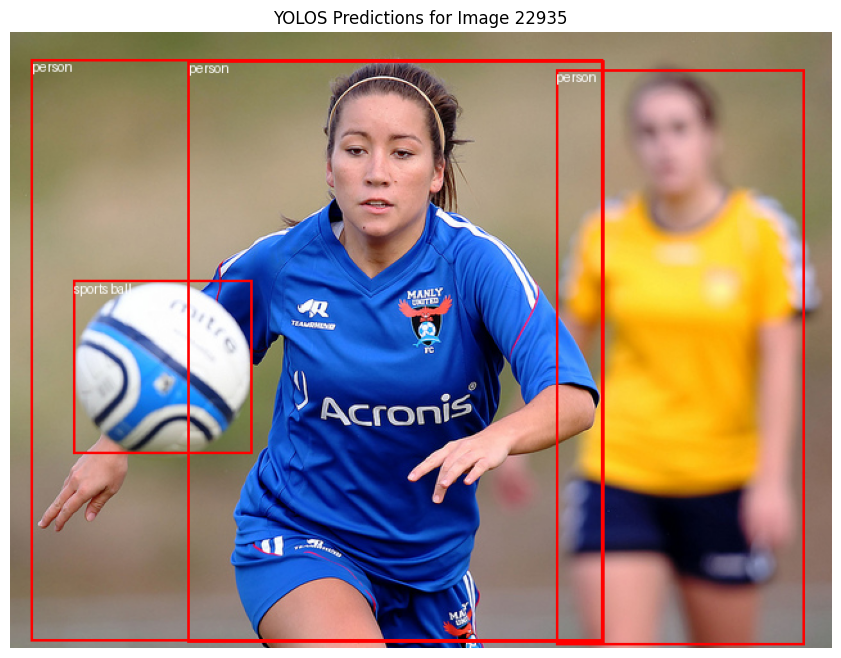

900it [03:34,  4.20it/s]


mAP@[0.5:0.95]: tensor(0.3324)
Detailed mAP results: {'map': tensor(0.3324), 'map_50': tensor(0.5127), 'map_75': tensor(0.3428), 'map_small': tensor(0.0977), 'map_medium': tensor(0.3187), 'map_large': tensor(0.5092), 'mar_1': tensor(0.2832), 'mar_10': tensor(0.4113), 'mar_100': tensor(0.4224), 'mar_small': tensor(0.1505), 'mar_medium': tensor(0.3991), 'mar_large': tensor(0.5929), 'map_per_class': tensor(-1.), 'mar_100_per_class': tensor(-1.), 'classes': tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
        36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
        54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71,
        72, 73, 74, 75, 76, 77, 78, 79], dtype=torch.int32)}
Baseline Performance (mAP): tensor(0.3324)
Baseline Performance (mAP):
        map    map_50    map_75  map_small  map_medium  map_large     mar_1  \
0  0.332379

,map,map_50,map_75,map_small,map_medium,map_large,mar_1,mar_10,mar_100,mar_small,mar_medium,mar_large,map_per_class,mar_100_per_class
0,0.332379,0.512714,0.342762,0.097738,0.318657,0.509172,0.283184,0.411286,0.4224,0.150513,0.399143,0.592925,-1.0,-1.0


In [ ]:
baseline_results = evaluate_model(original_model,processor, test_dataset, yolos_categories)
print("Baseline Performance (mAP):", baseline_results["map"])

baseline_results_dict = {
    key: value.item() if isinstance(value, torch.Tensor) else value
    for key, value in baseline_results.items()
    if key != "classes"
}
baseline_results_df = pd.DataFrame([baseline_results_dict])
print("Baseline Performance (mAP):")
print(baseline_results_df)
display(baseline_results_df)


## **6. Implementing LoRA Variants**


### Inspecting Potential Layers

In [ ]:
model = YolosForObjectDetection.from_pretrained(model_name).to(device)
for name, param in model.named_parameters():
    print(name)


vit.embeddings.cls_token
vit.embeddings.detection_tokens
vit.embeddings.position_embeddings
vit.embeddings.patch_embeddings.projection.weight
vit.embeddings.patch_embeddings.projection.bias
vit.encoder.mid_position_embeddings
vit.encoder.layer.0.attention.attention.query.weight
vit.encoder.layer.0.attention.attention.query.bias
vit.encoder.layer.0.attention.attention.key.weight
vit.encoder.layer.0.attention.attention.key.bias
vit.encoder.layer.0.attention.attention.value.weight
vit.encoder.layer.0.attention.attention.value.bias
vit.encoder.layer.0.attention.output.dense.weight
vit.encoder.layer.0.attention.output.dense.bias
vit.encoder.layer.0.intermediate.dense.weight
vit.encoder.layer.0.intermediate.dense.bias
vit.encoder.layer.0.output.dense.weight
vit.encoder.layer.0.output.dense.bias
vit.encoder.layer.0.layernorm_before.weight
vit.encoder.layer.0.layernorm_before.bias
vit.encoder.layer.0.layernorm_after.weight
vit.encoder.layer.0.layernorm_after.bias
vit.encoder.layer.1.attention.

### Define Target Modules

In [ ]:
target_modules = [
    f"vit.encoder.layer.{i}.attention.attention.query" for i in range(12)
] + [
    f"vit.encoder.layer.{i}.attention.attention.value" for i in range(12)
]


### Functions for Model Training

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, data_list):
        self.data = data_list

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

# Train
train_dataset_list = list(train_dataset)
train_dataset_fixed = CustomDataset(train_dataset_list)

# Val
train_val_dataset_list = list(train_val_dataset)
train_val_dataset_fixed = CustomDataset(train_val_dataset_list)


In [ ]:
def collate_fn(batch):
    images = [sample["image"].convert("RGB") if sample["image"].mode != "RGB" else sample["image"] for sample in batch]

    annotations = []
    for sample in batch:
        image_id = sample["image_id"]

        if "objects" in sample and "category" in sample["objects"] and "bbox" in sample["objects"]:
            formatted_annotations = [
                {
                    "bbox": bbox,
                    "category_id": coco_to_yolos_mapping.get(cat_id, None),  # Map COCO to YOLOS categories
                    "area": area
                }
                for bbox, cat_id, area in zip(sample["objects"]["bbox"], sample["objects"]["category"], sample["objects"]["area"])
                if coco_to_yolos_mapping.get(cat_id, None) is not None  # Exclude invalid categories
            ]
            annotations.append({
                "image_id": image_id,
                "annotations": formatted_annotations
            })
        else:
            annotations.append({"image_id": image_id, "annotations": []})

    # Use processor to handle resizing, padding, and bounding box adaptation
    # from COCO [x_min, y_min, width, hight] to YOLOS [x_center, y_center, width, height]
    inputs = processor(images=images, annotations=annotations, return_tensors="pt")

    # Extract processed images and labels
    processed_images = inputs["pixel_values"]
    labels = inputs["labels"]

    return {"pixel_values": processed_images, "labels": labels}


train_dataloader = DataLoader(train_dataset_fixed, batch_size=4, shuffle=True, collate_fn=collate_fn)
val_dataloader = DataLoader(train_val_dataset_fixed, batch_size=4, shuffle=False, collate_fn=collate_fn)


In [ ]:
# Early Stopping - stop training if mAP does not improve
class EarlyStopping:
    def __init__(self, patience=3, min_delta=0.001):
        self.patience = patience
        self.min_delta = min_delta
        self.best_map = -float("inf")
        self.counter = 0

    def __call__(self, current_map):
        if current_map > self.best_map + self.min_delta:
            self.best_map = current_map
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                print("Early stopping triggered - Training Stopped!")
                return True  # sign to stop training
        return False


In [ ]:
def focal_loss(logits, targets, alpha=0.25, gamma=2.0, null_labels={0, 12, 26, 29, 30, 45, 66, 68, 69, 71, 83}):
    batch_size, num_queries, num_classes = logits.shape
    device = logits.device
    null_labels_tensor = torch.tensor(list(null_labels), device=device)
    log_probs = F.log_softmax(logits, dim=-1)
    target_tensor = torch.full((batch_size, num_queries), fill_value=-1, dtype=torch.long, device=device) # -1 means ignored label

    for i in range(batch_size):
        if "class_labels" not in targets[i]:
            continue
        labels = targets[i]["class_labels"].to(device)
        valid_labels = labels[~torch.isin(labels, null_labels_tensor)] # Filter out null labels
        num_valid_labels = min(valid_labels.numel(), num_queries)
        target_tensor[i, :num_valid_labels] = valid_labels[:num_valid_labels]

    # Apply mask to ignore invalid labels
    valid_mask = target_tensor != -1
    gathered_log_probs = log_probs[torch.arange(batch_size).unsqueeze(1), torch.arange(num_queries).unsqueeze(0), target_tensor]
    gathered_log_probs = gathered_log_probs * valid_mask

    # Compute focal loss
    pt = gathered_log_probs.exp()
    focal_weight = alpha * (1 - pt) ** gamma
    loss = -focal_weight * gathered_log_probs
    loss = loss.sum() / valid_mask.sum()
    return loss


### Training Function

In [ ]:
def train_model(model, processor, train_dataloader, val_dataloader, optimizer, scheduler, early_stopping, device, output_model_path, epochs=5, accumulation_steps=4, is_plateau_scheduler=False):
    model.to(device)
    model.train()

    epochs_list = []
    train_total_losses = []
    val_total_losses = []
    train_focal_losses = []
    train_bbox_losses = []
    train_giou_losses = []
    mAP_scores = []

    best_mAP_score = 0

    for epoch in range(epochs):
        total_loss = 0
        skipped_batches = 0
        epoch_focal_loss = 0
        epoch_bbox_loss = 0
        epoch_giou_loss = 0

        model.train()

        optimizer.zero_grad()

        for batch_idx, batch in enumerate(tqdm(train_dataloader)):
            batch_inputs = batch["pixel_values"].to(device)
            batch_labels = [{k: v.to(device) for k, v in label.items()} for label in batch["labels"]]

            outputs = model(**{"pixel_values": batch_inputs}, labels=batch_labels)

            if outputs.loss is None:
                print(f"No loss for batch {batch_idx}, skipping")
                skipped_batches += 1
                continue

            # Loss components (with focal loss instead of the default-CE)
            loss_focal = focal_loss(outputs.logits, batch_labels)
            loss_bbox = outputs.loss_dict["loss_bbox"]
            loss_giou = outputs.loss_dict["loss_giou"]
            total_loss_batch = 1.5 * loss_focal + 1.0 * loss_bbox + 2.0 * loss_giou

            # Gradient accumulation
            scaled_loss = total_loss_batch / accumulation_steps
            scaled_loss.backward()

            if (batch_idx + 1) % accumulation_steps == 0 or (batch_idx + 1 == len(train_dataloader)):
                optimizer.step()
                optimizer.zero_grad()

            total_loss += total_loss_batch.item()
            epoch_focal_loss += loss_focal.item()
            epoch_bbox_loss += loss_bbox.item()
            epoch_giou_loss += loss_giou.item()

            if batch_idx % 10 == 0:
                print(f"Epoch {epoch + 1}, Batch {batch_idx}: Loss = {scaled_loss.item():.4f}")

            # Clear memory after processing batch
            del batch, batch_inputs, batch_labels, outputs
            torch.cuda.empty_cache()

        # Compute average training losses
        num_batches = len(train_dataloader) - skipped_batches
        avg_train_loss = total_loss / num_batches if num_batches > 0 else 0
        avg_focal_loss = epoch_focal_loss / num_batches if num_batches > 0 else 0
        avg_bbox_loss = epoch_bbox_loss / num_batches if num_batches > 0 else 0
        avg_giou_loss = epoch_giou_loss / num_batches if num_batches > 0 else 0

        print(f"Epoch {epoch + 1} Complete. Average train Loss: {avg_train_loss:.4f}, Skipped Batches: {skipped_batches}")

        # Store losses
        epochs_list.append(epoch + 1)
        train_total_losses.append(avg_train_loss)
        train_focal_losses.append(avg_focal_loss)
        train_bbox_losses.append(avg_bbox_loss)
        train_giou_losses.append(avg_giou_loss)

        # Evaluation on Validation Set
        model.eval()
        total_val_loss = 0
        skipped_val_batches = 0
        with torch.no_grad():
            for val_batch in tqdm(val_dataloader, desc="Validating"):
                val_batch_inputs = val_batch["pixel_values"].to(device)
                val_batch_labels = [{k: v.to(device) for k, v in label.items()} for label in val_batch["labels"]]

                val_outputs = model(**{"pixel_values": val_batch_inputs}, labels=val_batch_labels)

                if val_outputs.loss is None:
                    print(f"No loss for a validation batch, skipping")
                    skipped_val_batches += 1
                    continue

                val_loss_focal = focal_loss(val_outputs.logits, val_batch_labels)
                val_loss_bbox = val_outputs.loss_dict["loss_bbox"]
                val_loss_giou = val_outputs.loss_dict["loss_giou"]
                val_loss_batch = 1.5 * val_loss_focal + 1.0 * val_loss_bbox + 2.0 * val_loss_giou
                total_val_loss += val_loss_batch


        num_val_batches = len(val_dataloader) - skipped_val_batches
        avg_val_loss = total_val_loss / num_val_batches if num_val_batches > 0 else 0
        val_total_losses.append(avg_val_loss)
        print(f"Epoch {epoch+1} - Validation Loss: {avg_val_loss:.4f}")

        # Evaluate mAP on Validation Set
        model_val_results = evaluate_model(model, processor, train_val_dataset_fixed, yolos_categories)
        epoch_val_mAP_score = model_val_results['map'].item()
        print(f"Epoch {epoch+1} - Validation mAP Score: {epoch_val_mAP_score:.4f}")
        mAP_scores.append(epoch_val_mAP_score)

        model_val_results_dict = {key: value.item() if isinstance(value, torch.Tensor) else value
                                  for key, value in model_val_results.items()
                                  if key != "classes"}
        model_val_results_df = pd.DataFrame([model_val_results_dict])
        display(model_val_results_df)

        # Save the best model based on mAP score
        if epoch_val_mAP_score > best_mAP_score:
            best_mAP_score = epoch_val_mAP_score
            torch.save(model, output_model_path)
            print(f"Best model saved with mAP {best_mAP_score:.4f} at epoch {epoch + 1}")

        # Update scheduler based on validation loss
        if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
            scheduler.step(avg_val_loss)
        else:
            scheduler.step()

        # Check if needed to stop training
        if early_stopping(epoch_val_mAP_score):
            break

    return best_mAP_score, epochs_list, train_total_losses, val_total_losses, train_focal_losses, train_bbox_losses, train_giou_losses, mAP_scores



### Evaluate Model Functions

In [ ]:
def convert_to_numpy(data):
    if isinstance(data, torch.Tensor):
        return data.cpu().detach().numpy()
    elif isinstance(data, list):
        return [convert_to_numpy(item) for item in data]
    return data

def plot_loss_graphs(epochs_list, train_total_losses, train_focal_losses, train_bbox_losses, train_giou_losses, val_total_losses):
    epochs_list = convert_to_numpy(epochs_list)
    train_total_losses = convert_to_numpy(train_total_losses)
    train_focal_losses = convert_to_numpy(train_focal_losses)
    train_bbox_losses = convert_to_numpy(train_bbox_losses)
    train_giou_losses = convert_to_numpy(train_giou_losses)
    val_total_losses = convert_to_numpy(val_total_losses)

    # Plot 1: Total Training Loss over Epochs
    plt.figure(figsize=(10, 5))
    plt.plot(epochs_list, train_total_losses, label="Train Loss", linestyle="-", marker="o", color="blue")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Train Loss Over Epochs")
    plt.legend()
    plt.grid()
    plt.show()

    # Plot 2: Training Loss Components Over Epochs
    plt.figure(figsize=(8, 6))
    plt.plot(epochs_list, train_focal_losses, label="Train Focal Loss", linestyle="--", marker="x", color="orange")
    plt.plot(epochs_list, train_bbox_losses, label="Train BBox Loss", linestyle="--", marker="s", color="green")
    plt.plot(epochs_list, train_giou_losses, label="Train GIoU Loss", linestyle="--", marker="d", color="red")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Train Loss Components Over Epochs")
    plt.legend()
    plt.grid()
    plt.show()

    # Plot 3: Training and Validation Loss Over Epochs
    plt.figure(figsize=(10, 5))
    plt.plot(epochs_list, train_total_losses, label="Train Loss", linestyle="-", marker="o", color="blue")
    plt.plot(epochs_list, val_total_losses, label="Validation Loss", linestyle="--", marker="x", color="green")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss Over Epochs")
    plt.legend()
    plt.grid()
    plt.show()
